<a href="https://colab.research.google.com/github/bsinha/LearningQC/blob/main/FraudDetection_Classical_vs_Quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240318%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240318T151708Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c0d161b408c60f43223bc4d8a2bb1864f2c9994abc8f54a1aa476fba69c32b18d69d143099b9b51374d65a75bcb9e37b656eb03341bc3604d19fb39fe6a63d2bd67556ffd8349b5794810185e0f5643298457cc5e79fbb5850565167ad2f5c7af4d4e62fc17925e9b979ac46092aba5901e7d8e4bbb655bbe76270433e67c9766e3f205f9600e4d9c9a429b024a46e1176362c55abff7bea1a412151bb7f05779154a654791c7c3362c0907cd4a1957308b83e8c7275ab7d76106857ef1a18b0a6b85c72ebd977d51e985809a9af8fd75770c7ec9f74905a759f74ab486476220b3ef74395039a205705166f45f658078a960f7958740526c8477fe92a2d5dd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


# Fraud Detection Prediction - Comparing Classical Vs Quantum

## Classical Models Used :
* Linear Model
* K-Nearest Neighbour
* Naiyve Bayes
* Support Vector Machine (Sigmoid, Linear, Poly, RBF)
* Decision Tree
* Random Forest
    
## Quantum Models Used:
* Variational Quantum Classifier

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


#1. Data Exploration

## Load data from CSV file

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.describe().T # Data Summary

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

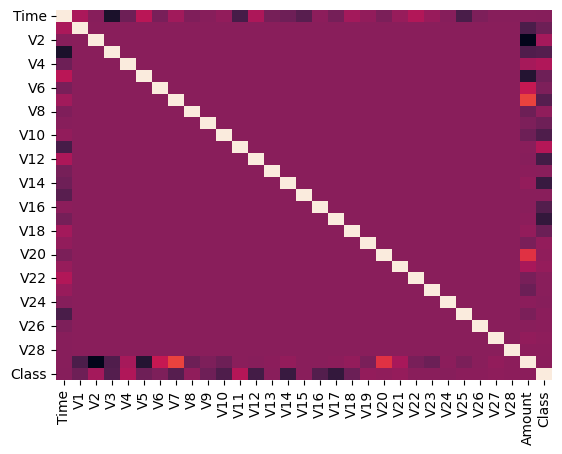

In [7]:
import seaborn as sns
sns.heatmap(df.corr(), annot=False, fmt=".2f", cbar=False)
plt.show()

## Understanding and evaluating data
* Since, we are unable to see data from other than Class 0, we need data evaluation.
* Plus, the number of instances of fraudelent data are less in numbers we need to pump-up the fraudelent data.

In [8]:
df.shape #Prints number of rows and columns

(284807, 31)

In [9]:
class_count = df["Class"].value_counts()
class_count

0    284315
1       492
Name: Class, dtype: int64

In [10]:
print("Class 0 :" , class_count[0])
print("Class 1 :" , class_count[1])

Class 0 : 284315
Class 1 : 492


In [11]:
df.shape

(284807, 31)

Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, pieces
0: 284315
1: 492
Imbalance degree: 1: 577.88
 
Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, %
Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


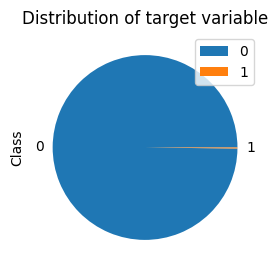

In [20]:
import pylab
pylab.rcParams['figure.figsize'] = (8, 5)

# Target distribution
print('Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, pieces')
target_count = df['Class'].value_counts()
print('0:', target_count[0])
print('1:', target_count[1])
print('Imbalance degree:', '1:', round(target_count[0] / target_count[1], 2))
print (' ')
print('Target distribution "1" и "0" in column "Class", legal and fraudulent transactions, respectively, %')
print((df.groupby('Class')['Class'].count()/df['Class'].count())*100)


pylab.rcParams['figure.figsize'] = (4, 3)
target_count.plot(kind='pie', title='Distribution of target variable', legend="true");

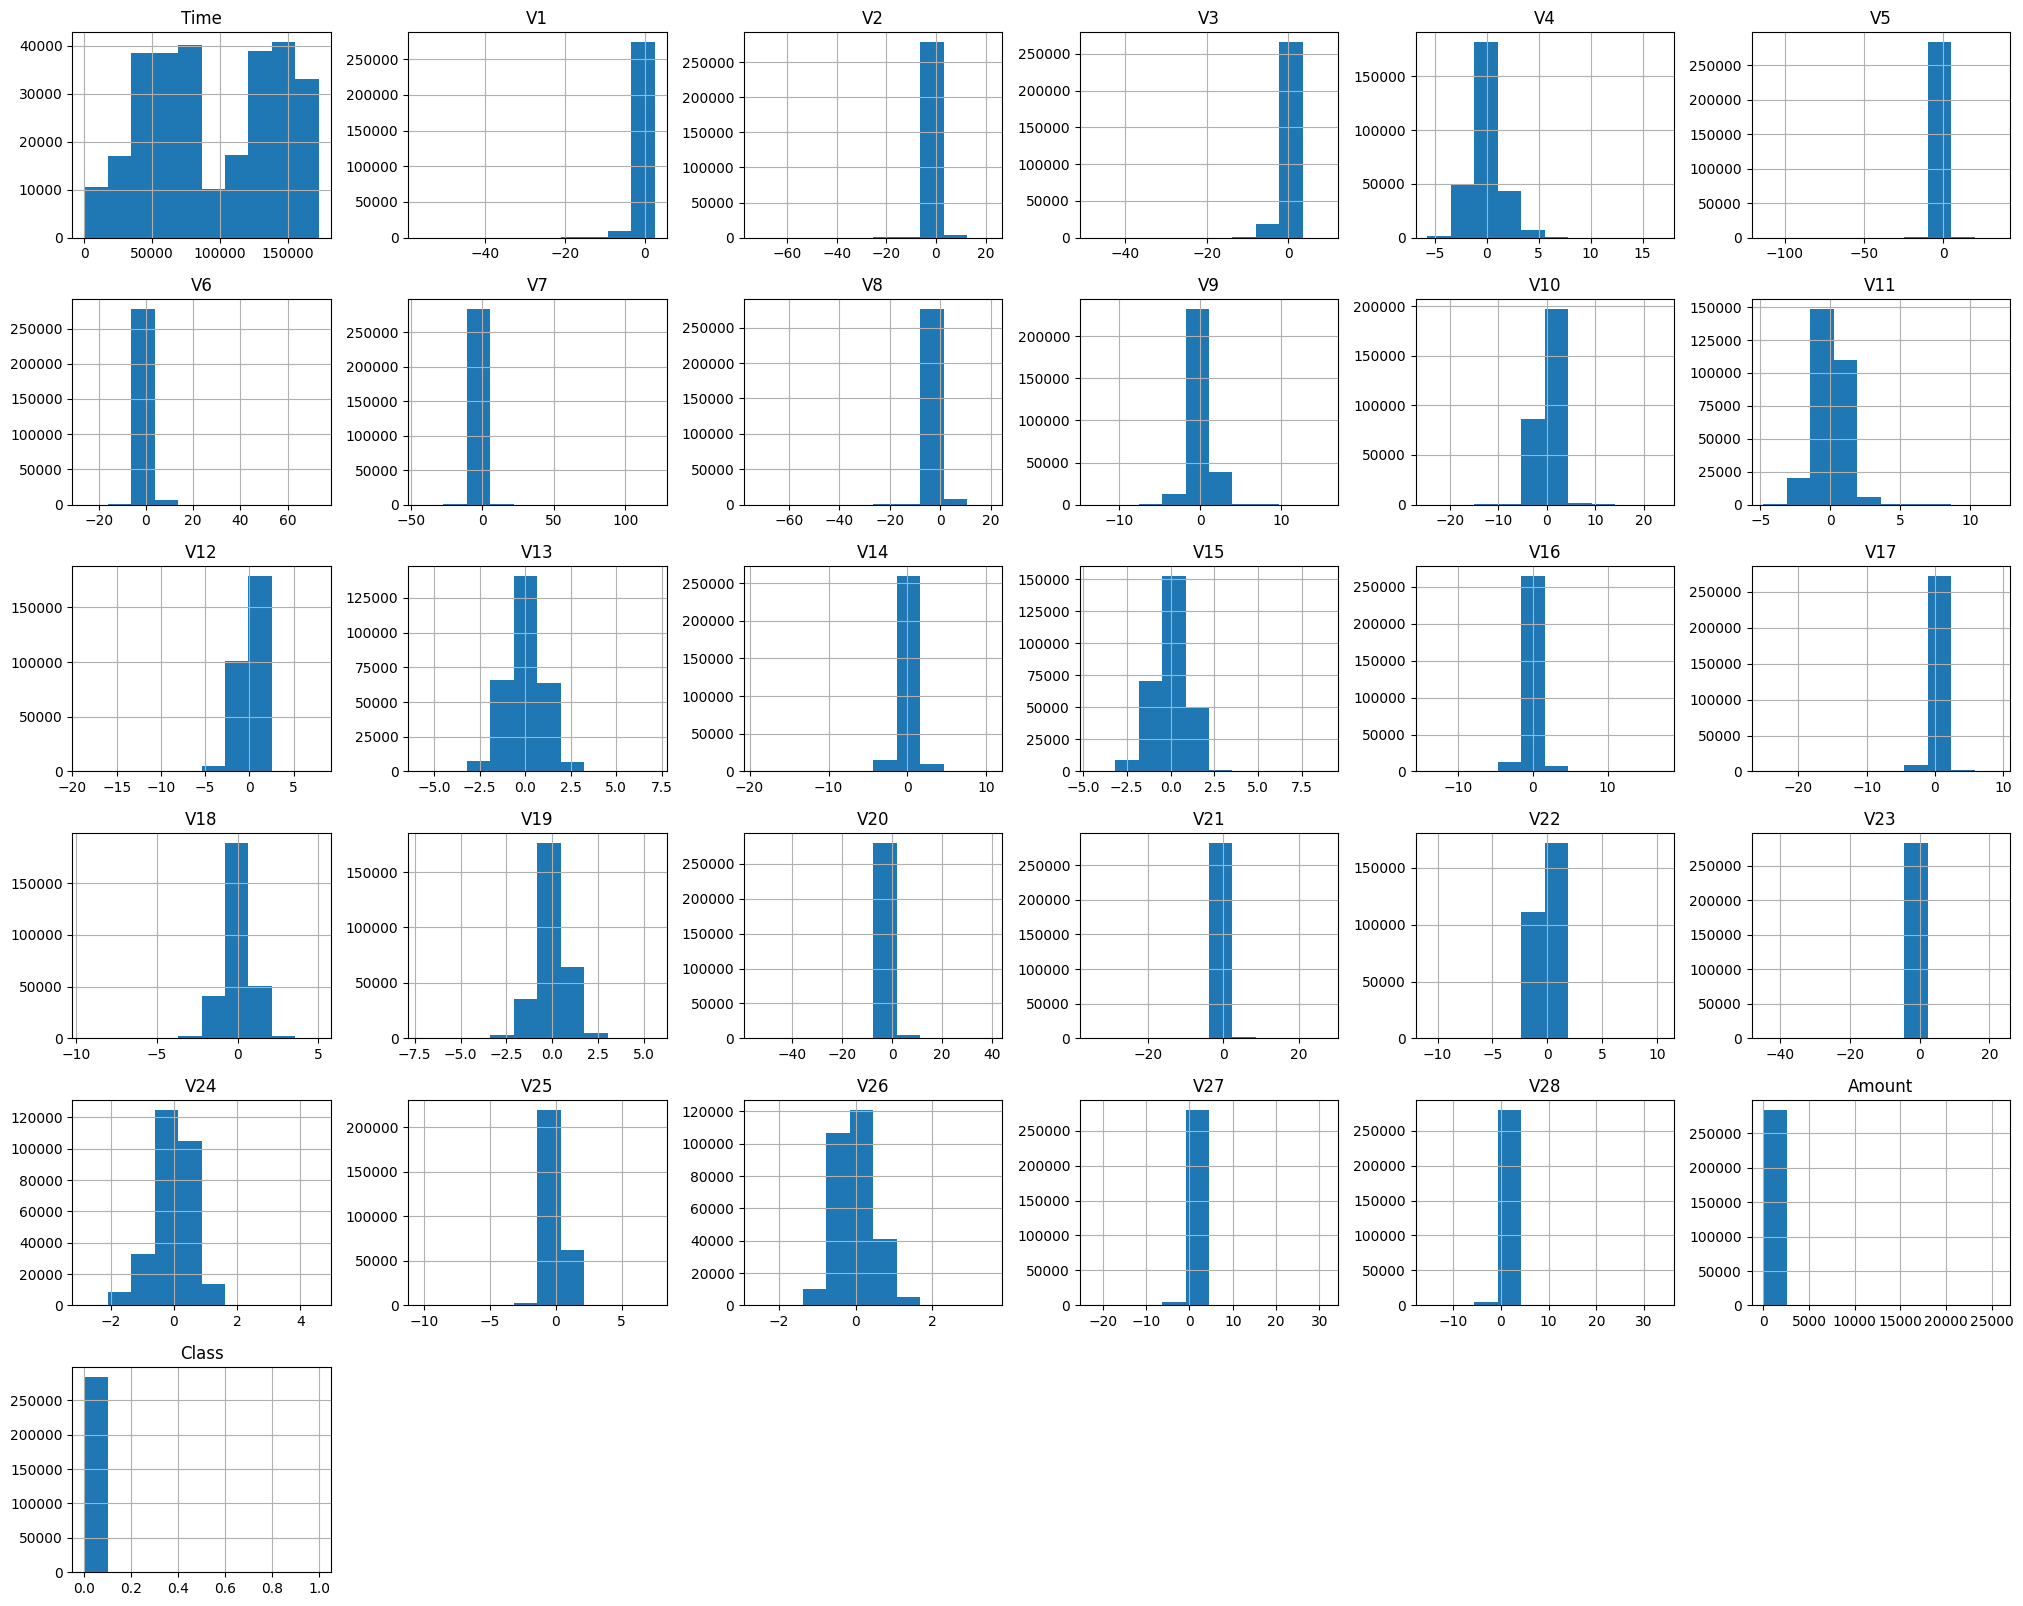

In [21]:
df.hist(figsize=(25,20))
plt.show()

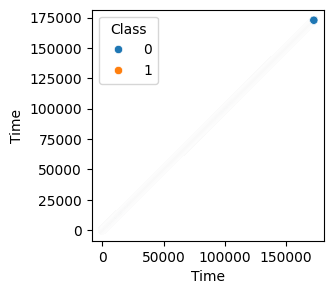

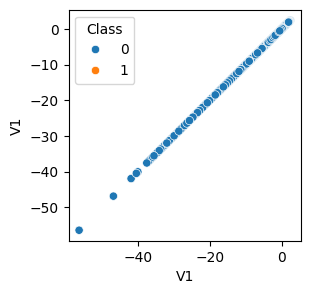

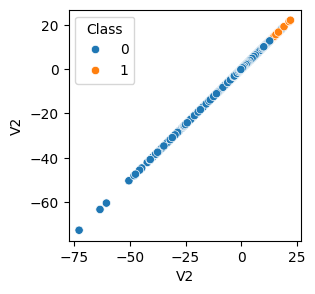

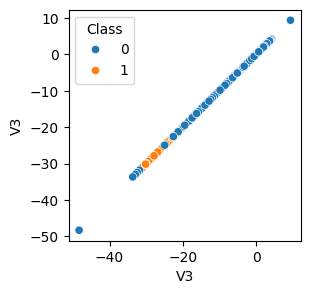

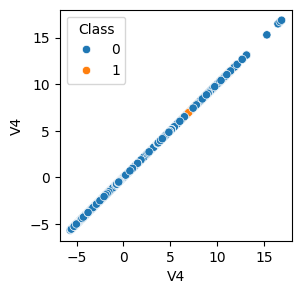

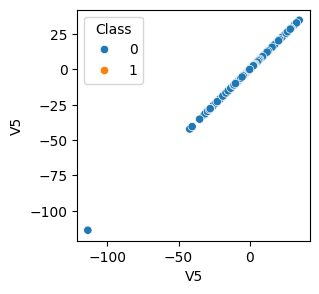

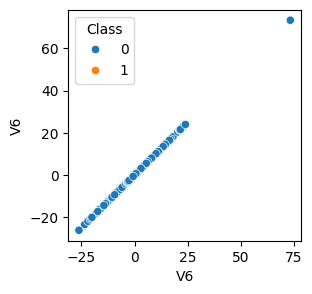

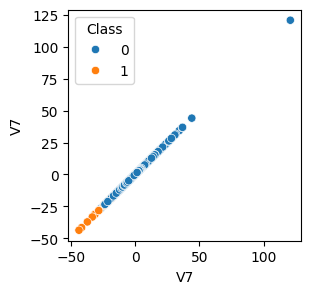

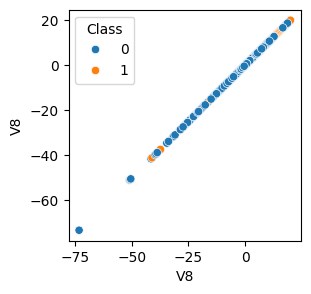

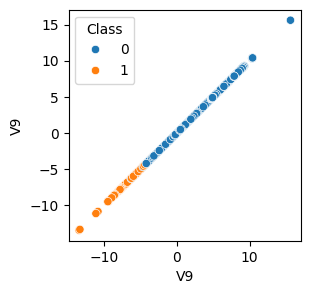

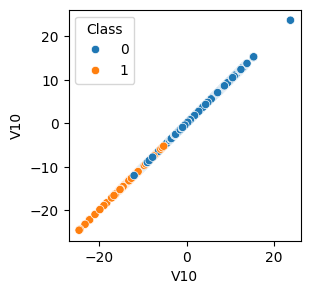

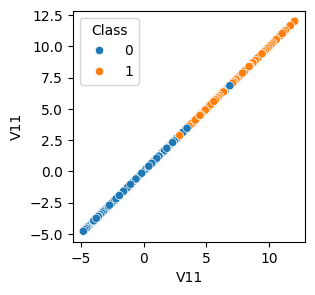

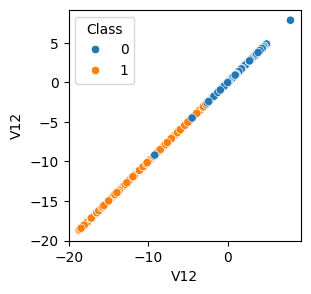

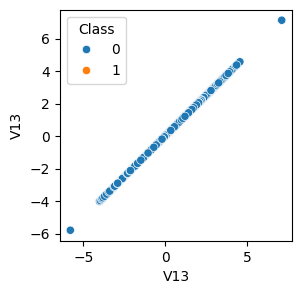

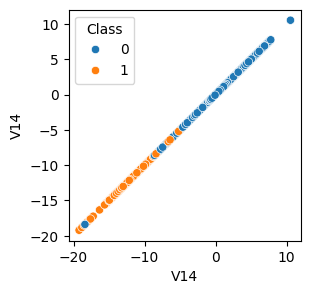

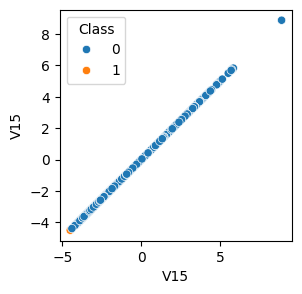

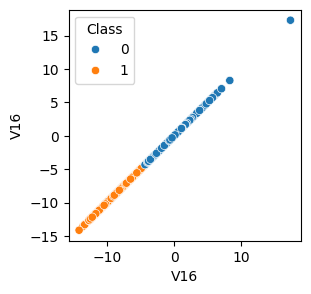

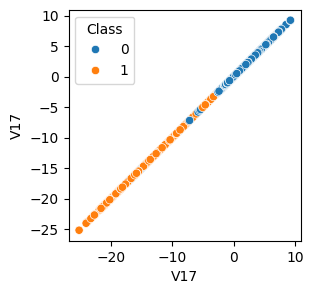

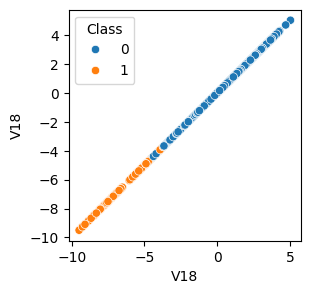

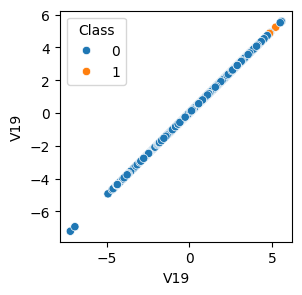

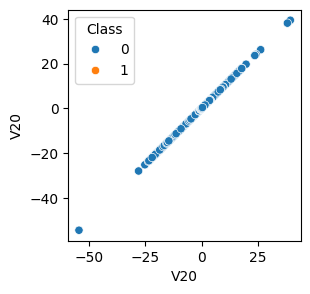

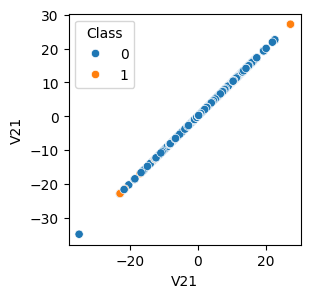

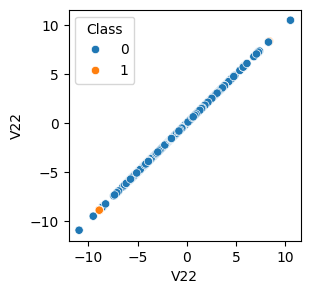

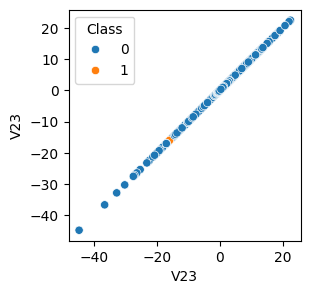

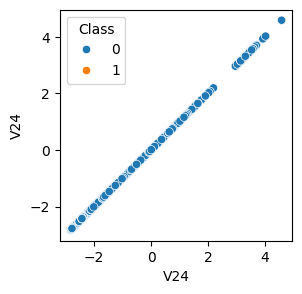

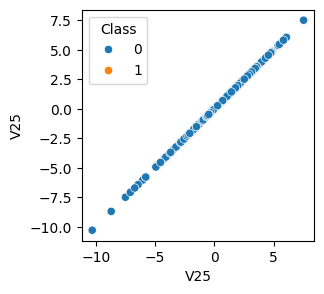

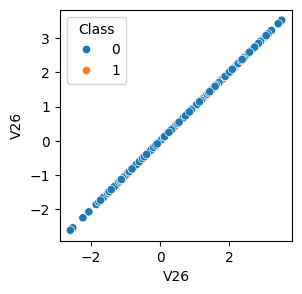

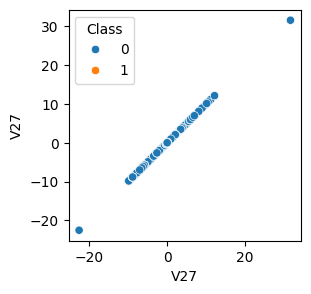

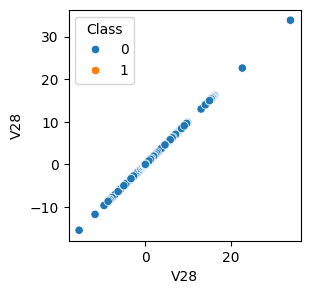

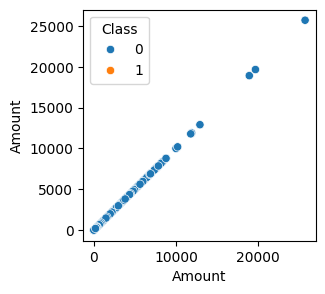

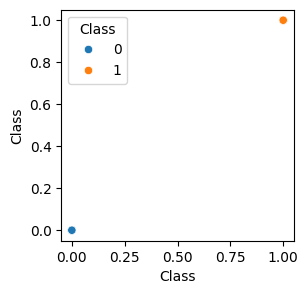

In [22]:
import numpy as np

features = list(df.columns)  # Assuming "Class" is not a feature
correlations = np.abs(df.corr())  # Get absolute correlations
strong_correlations = np.where(correlations > 0.7)  # Adjust threshold as needed
feature_pairs = [(features[i], features[j]) for i, j in zip(*strong_correlations)]



for x, y in feature_pairs:
    plt.figure(figsize=(3,3))
    #plt.subplots(2,2,figsize=(3,3) )
    sns.scatterplot(x=x, y=y, hue="Class", data=df, palette="tab10")
    plt.show()


In [23]:
#sns.pairplot(df.sample(1000), hue="Class", palette="tab10")
#plt.show()
# Reduce data size (optional)
# sample_size = 1000
# df_sample = df.sample(sample_size)

# Use individual scatter plots
#import matplotlib.pyplot as plt

#features = list(df.columns)  # Assuming "Class" is not a feature

#for i in range(len(features) - 1):
#  for j in range(i + 1, len(features)):
#    sns.scatterplot(
#        x=features[i], y=features[j], hue="Class", data=df, palette="tab10",
#    )
#    plt.show()  # Display each plot individually

# Free up memory (optional)
import gc; gc.collect()


54644

## Data Cleansing
* Since, the number of instances of 0 is 284315 and for Class 1 it is mere 492, we need to balance the data by pumping up data for Class 1.
* But prior to that, we need to figure out instances of duplicates and clean the data from such instances

### Removing Duplicates

In [24]:
df.duplicated().any
df.duplicated().sum()

1081

In [28]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## Solving Data Imbalance Problem

### Now, lets pump up the data for Class- 1

#### Get X-Axis and Y-Axis data

In [25]:
# Taking columns v1 to v28 plus amount and remocing Class
x= df.iloc[:,1:29].values # Remove .values to view data in tabular structure
x

array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
        -1.89114844e-01,  1.33558377e-01, -2.10530535e-02],
       [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
         1.25894532e-01, -8.98309914e-03,  1.47241692e-02],
       [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
        -1.39096572e-01, -5.53527940e-02, -5.97518406e-02],
       ...,
       [ 1.91956501e+00, -3.01253846e-01, -3.24963981e+00, ...,
        -8.73705959e-02,  4.45477214e-03, -2.65608286e-02],
       [-2.40440050e-01,  5.30482513e-01,  7.02510230e-01, ...,
         5.46668462e-01,  1.08820735e-01,  1.04532821e-01],
       [-5.33412522e-01, -1.89733337e-01,  7.03337367e-01, ...,
        -8.18267121e-01, -2.41530880e-03,  1.36489143e-02]])

In [26]:
# Considering class as Y attribute
y = df.iloc[:,30].values
y

array([0, 0, 0, ..., 0, 0, 0])

#### Over Sampling the data

In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x,y)
print(x_resampled)
print(y_resampled)

[[-1.35980713 -0.07278117  2.53634674 ... -0.18911484  0.13355838
  -0.02105305]
 [ 1.19185711  0.26615071  0.16648011 ...  0.12589453 -0.0089831
   0.01472417]
 [-1.35835406 -1.34016307  1.77320934 ... -0.13909657 -0.05535279
  -0.05975184]
 ...
 [-2.86979495  1.33566696 -1.0095302  ... -0.45365101  0.34919104
   0.19886227]
 [-2.78724793 -0.07134038 -1.50528778 ... -0.26589432  0.22069402
   0.25607687]
 [-3.36531852  2.42650326 -3.75222653 ... -1.05599733 -1.20016497
  -1.01206584]]
[0 0 0 ... 1 1 1]


In [28]:
from collections import Counter
Counter(y_resampled).items()
# Now, we can see that the data for both Class 0 and Clas 1 are now same. So the data is Balanced.

dict_items([(0, 284315), (1, 284315)])

## Data Division into test and train data

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test =  train_test_split(x_resampled,y_resampled, test_size = 0.2)

print("X-train", len(x_train))
print("X-test", len(x_test))
print("Y-train", len(y_train))
print("Y-test", len(y_test))

labels = ['Class 0', 'Class 1']

X-train 453204
X-test 113302
Y-train 453204
Y-test 113302


# 2. Applying Models and Prediction of Fraud

## Functions used during Modelling and Prediction

In [34]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix based on true and predicted labels.

    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels.
    y_pred : array-like of shape (n_samples,)
        Predicted labels.
    labels : list of str
        List of class labels.
    """
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualize confusion matrix using heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()



In [35]:
# The ROC curve plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis as the discrimination threshold is varied.
#  - It helps visualize the model's ability to distinguish between fraudulent and legitimate transactions.
#  - A model with a higher AUC (Area Under the Curve) is generally better at discrimination.

def plot_roc_curve(y_true, y_pred):
  """
  Plots the ROC curve for a model.

  Parameters:
    y_true : array-like of shape (n_samples,)
      True labels.
    y_pred : array-like of shape (n_samples,)
      Predicted probabilities.
  """
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--', label='No Discrimination')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()



In [36]:
# Precision-Recall Curve(Use for Imbalanced DataSet):

# - The precision-recall curve plots Precision (positive predictive value) on the y-axis against Recall (true positive rate) on the x-axis as the classification threshold is varied.
# - This is useful when dealing with imbalanced datasets, where positive cases (fraudulent transactions) might be rare.
# - A model with a curve that stays closer to the top-left corner indicates a better balance between precision and recall.
def plot_precision_recall_curve(y_true, y_pred):
  """
  Plots the precision-recall curve for a model.

  Parameters:
    y_true : array-like of shape (n_samples,)
      True labels.
    y_pred : array-like of shape (n_samples,)
      Predicted labels.
  """
  precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, label='Precision-Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.show()



In [37]:
# Distribution Plots:

# - Create histograms or kernel density estimation (KDE) plots to visualize the distribution of features or predicted probabilities for both fraudulent and legitimate transactions.
# - This can help identify potential patterns or outliers that might be related to fraudulent activity.

def plot_distribution(data, feature_name, class_label="class_label", kind="kde"):
  """
  Plots the distribution of a feature for different classes.

  Parameters:
    data : pandas DataFrame
      DataFrame containing the data.
    feature_name : str
      Name of the feature to plot.
    class_label : str, optional
      Name of the class label column (default: "class_label").
    kind : str, optional
      Plot kind (e.g., "hist" for histogram, "kde" for kernel density estimation).
  """
  sns.displot(data=data, x=feature_name, hue=class_label, kind=kind)
  plt.title(f'Distribution of {feature_name} by {class_label}')
  plt.show()



In [38]:
def plot_predicted_probability_distribution(y_pred, bins=10):
  """
  Plots the distribution of predicted probabilities.

  Parameters:
    y_pred : array-like
      Array of predicted probabilities.
    bins : int, optional
      Number of bins for the histogram (default: 10).
  """
  sns.displot(y_pred, bins=bins, kde=True)
  plt.title('Distribution of Predicted Probabilities')
  plt.show()

In [39]:
from sklearn.metrics import accuracy_score

def show_result(y_test, y_pred, labels):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy::  {accuracy:.2f}")
    confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(y_test, y_pred, labels)
    plot_roc_curve(y_test, y_pred)
    plot_predicted_probability_distribution(y_pred)


## Model 1 - Logistic Regression Model

In [40]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(random_state=42)

logmodel.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [41]:
y_pred = logmodel.predict(x_test)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

In [42]:
y_test

array([0, 1, 1, ..., 1, 1, 1])

In [43]:
from sklearn.metrics import confusion_matrix
#plot_confusion_matrix(y_test, y_pred, labels)
confusion_matrix(y_test, y_pred)

array([[55326,  1319],
       [ 4909, 51748]])

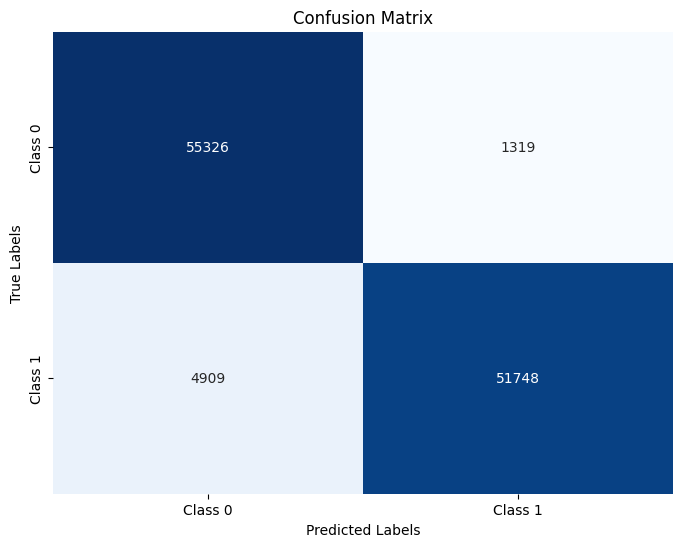

In [44]:
plot_confusion_matrix(y_test, y_pred, labels)

In [45]:
accuracy = logmodel.score(x_test, y_test)
print("Accuracy:: ", accuracy)

Accuracy::  0.9450318617500132


In [46]:
accuracy = accuracy_score(y_test, y_pred)

Accuracy::  0.95


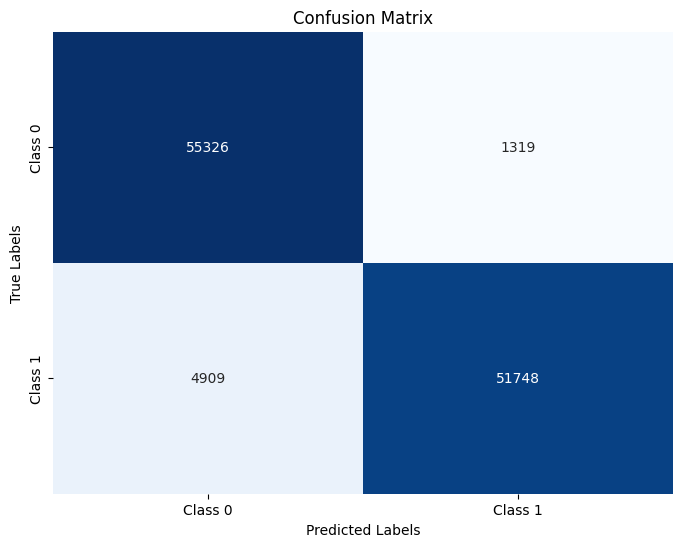

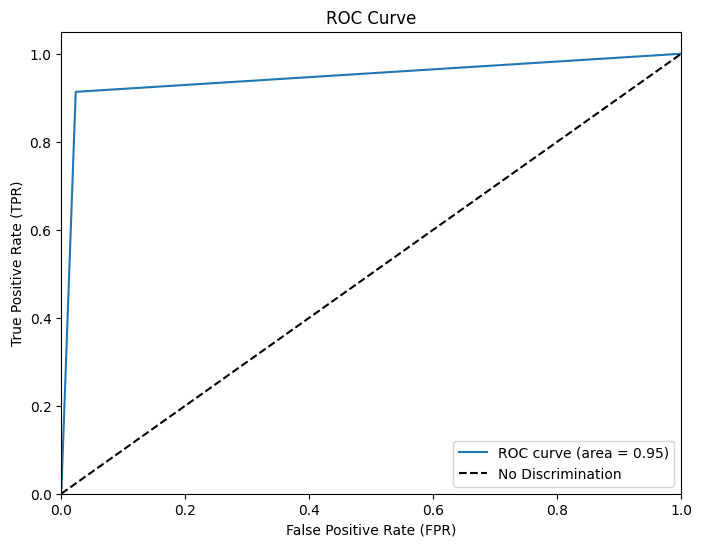

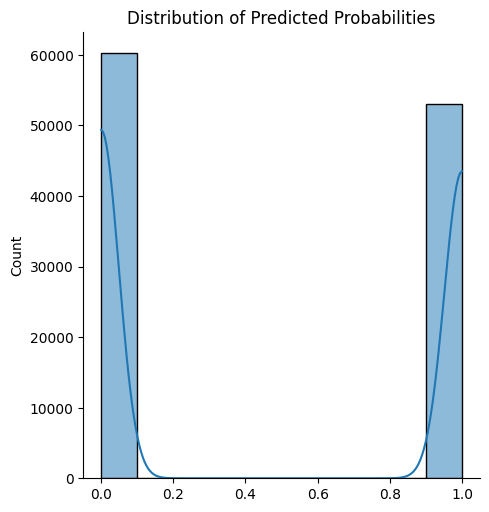

In [47]:
show_result(y_test, y_pred, labels)

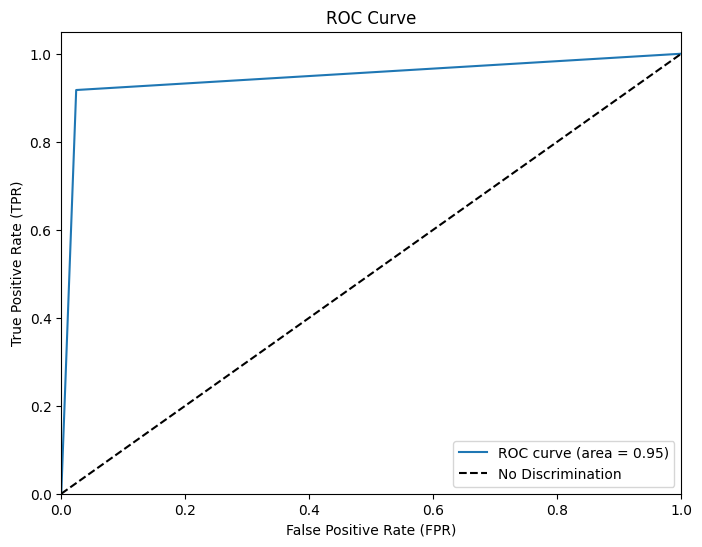

In [ ]:
plot_roc_curve(y_test, y_pred)

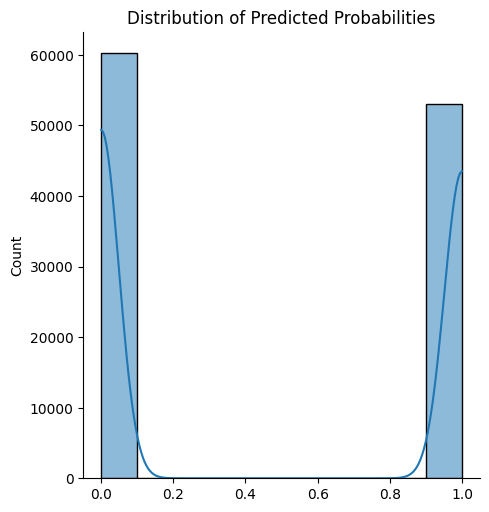

In [48]:
plot_predicted_probability_distribution(y_pred)

## Model 2. K Nearest Neighbour

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5, metric="minkowski", p=2)
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

In [50]:
y_pred = knn_model.predict(x_test)

In [51]:
confusion_matrix(y_test, y_pred)

array([[56608,    37],
       [    0, 56657]])

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:: ", accuracy)

Accuracy::  0.9996734391272881


Accuracy::  1.00


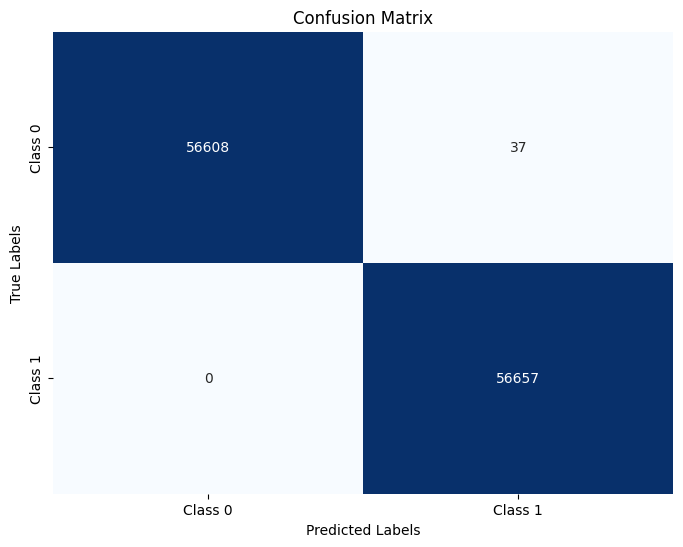

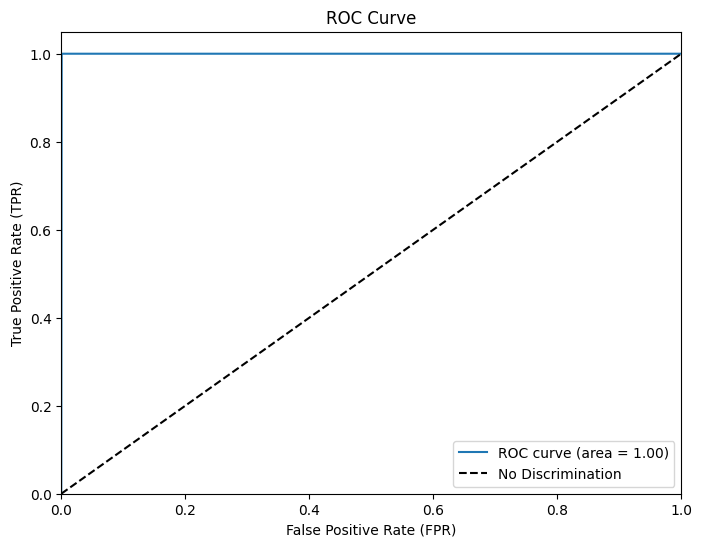

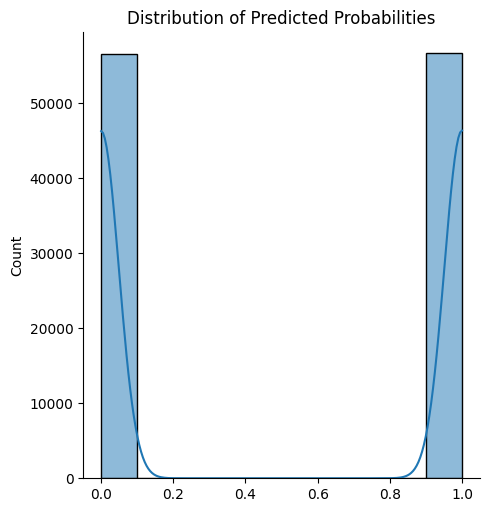

In [53]:
show_result(y_test, y_pred, labels)

## Model 3 - Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)


GaussianNB()

In [55]:
y_pred = nb_model.predict(x_test)

In [56]:
confusion_matrix(y_test, y_pred)

array([[55134,  1511],
       [ 8297, 48360]])

Accuracy::  0.91


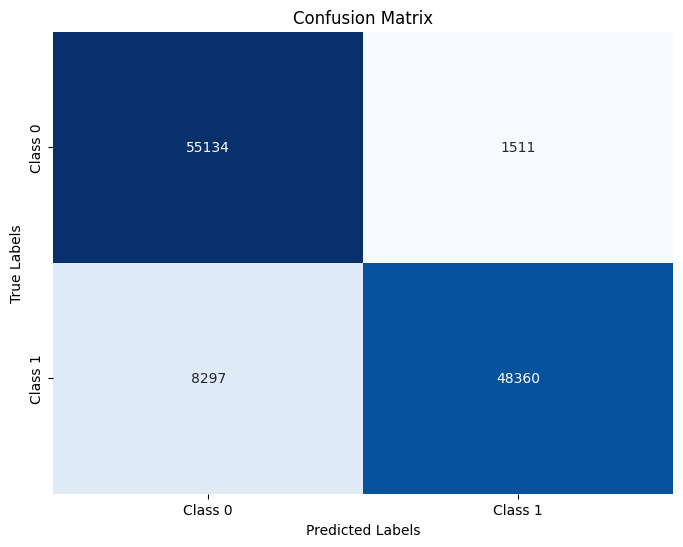

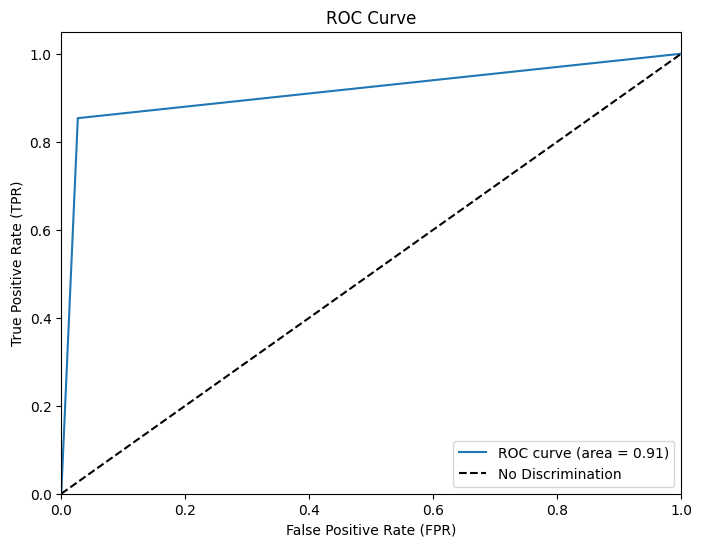

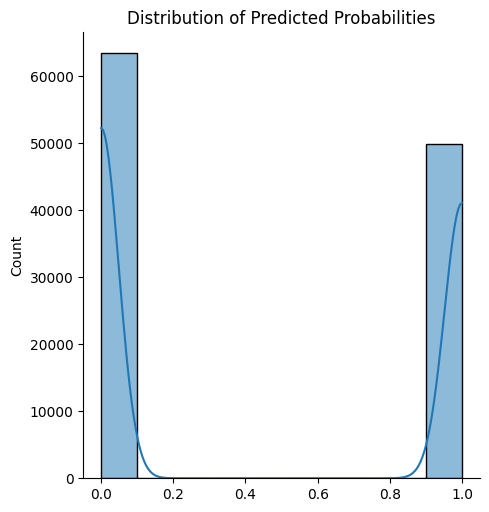

In [57]:
show_result(y_test, y_pred, labels)

## Model 4 - Support Vector Machine - SVM

### 1. Sigmoid

In [ ]:
from sklearn.svm import SVC

svm_model_sigmoid = SVC(kernel = 'sigmoid')
svm_model_sigmoid.fit(x_train, y_train)

In [ ]:
y_pred = svm_model_sigmoid.predict(x_test)

NameError: name 'svm_model_sigmoid' is not defined

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

### 2. Linear

In [1]:
from sklearn.svm import SVC

svm_model_linear = SVC(kernel="linear")
svm_model_linear.fit(x_train, y_train)

NameError: name 'x_train' is not defined

In [ ]:
y_pred = svm_model_linear.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

### 3. Poly

In [ ]:
svm_model_poly = SVC(kernel='poly')
svm_model_poly.fit(x_train, y_train)

In [ ]:
y_pred = svm_model_poly.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

### 4. RBF

In [ ]:
svm_model_rbf = SVC(kernel='rbf')
svm_model_rbf.fit(x_train, y_train)

In [ ]:
y_pred = svm_model_rbf.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

## Model 5 - Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtmodel = DecisionTreeClassifier(criterion="entropy")
dtmodel.fit(x_train, y_train)

In [ ]:
y_pred = dtmodel.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

## Model 6. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimator=3, criterion = 'entropy')
rfc_model.fit(x_train, y_train)

In [ ]:
y_pred =  rfc_model.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
show_result(y_test, y_pred, labels)

# 3. Conclusion